In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import mpl_toolkits
#from mpl_toolkits.basemap import Basemap
import pandas as pd
import xarray as xr
import Nio
print (Nio.__version__)
import seaborn as seabornInstance 
import sklearn

print("python version:")
import platform
print(platform.python_version())

1.5.5
python version:
3.7.3


# Load Data

In [3]:
sstdat = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc')
sst = sstdat['sst']
print(sst)
#note: lat & lon go by scale of 2 degrees


slpdat = xr.open_dataset('data/slp.mnmean.real.nc')
slp = slpdat['slp']
print(slp)
# https://www.metoffice.gov.uk/hadobs/hadslp2/data/hadslp2r.asc.gz
#note: lat & lon go by scale of 5 degrees


<xarray.DataArray 'sst' (time: 1997, lat: 89, lon: 180)>
[31991940 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-05-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]
<xarray.DataArray 'slp' (time: 2040, lat: 37, lon: 72)>
[5434560 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 85.0 80.0 75.0 70.0 ... -75.0 -80.0 -85.0 -90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * time     

In [4]:
dat = xr.open_dataset('/global/scratch/medhap02/ERA5_MSLP_SST_Td_tas_Jan1979toMay2020.grib',engine='pynio')

ERA5sst = dat['SSTK_GDS0_SFC_S123']
ERA5sst = ERA5sst.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

ERA5slp = dat['MSL_GDS0_SFC_S123']
ERA5slp = ERA5slp.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

print(ERA5sst)
print(ERA5slp)

<xarray.DataArray 'SSTK_GDS0_SFC_S123' (time: 497, lat: 721, lon: 1440)>
[516005280 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-05-01
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.25 359.5 359.75
Attributes:
    center:                          European Center for Medium-Range Weather...
    long_name:                       Sea surface temperature
    units:                           K
    level_indicator:                 [1]
    gds_grid_type:                   [0]
    parameter_table_version:         [128]
    parameter_number:                [34]
    forecast_time:                   [0]
    forecast_time_units:             hours
    statistical_process_descriptor:  average of N uninitialized analyses
    statistical_process_duration:    instantaneous (beginning at reference ti...
    N:                               [744 672 74

In [5]:
precipdat = xr.open_dataset('pALLIN.nc', decode_times=False)
print(precipdat)
time = pd.date_range('1874-05-01', freq='M', periods=1752)
precipALLIN = xr.Dataset({'data': ('data', precipdat['precip']), 'time': time, 'foo': ('int', np.arange(1752))})
precipALLIN

<xarray.Dataset>
Dimensions:  (time: 1752)
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 1748.0 1749.0 1750.0 1751.0
Data variables:
    precip   (time) float32 ...
Attributes:
    title:        
    description:  All-India Rainfall
    scripturl01:  https://climexp.knmi.nl/getindices.cgi?STATION=All-India_Ra...
    comment:      
    institution:  KNMI Climate Explorer
    scripturl02:  https://climexp.knmi.nl/dat2nc.cgi?id=$id&station=All-India...
    history:       2020-04-02  2:43:20 bin/dat2nc data/pALLIN.dat p All-India...
    Conventions:  CF-1.0


<xarray.Dataset>
Dimensions:  (data: 1752, int: 1752, time: 1752)
Coordinates:
  * data     (data) float32 19.6 10.7 14.5 33.9 63.6 ... 168.7 52.1 8.0 7.0
  * time     (time) datetime64[ns] 1874-05-31 1874-06-30 ... 2020-04-30
Dimensions without coordinates: int
Data variables:
    foo      (int) int64 0 1 2 3 4 5 6 7 ... 1745 1746 1747 1748 1749 1750 1751

# EPT

In [27]:
#EP-ENSOpredictor
#NOAA

#DSST1
latrange1 = sst.sel(lat = slice(5, -20)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = sst.sel(lat = slice(5, -20), lon = slice(150, 170), time = (sst['time.month']==3))
marchSST1 = marchdata1.sel(time = slice('1979-03-01', '2019-03-01'))
marchmean1 = (marchSST1*weights1).mean({'lon', 'lat'})/weights1.mean() 

maydata1 = sst.sel(lat = slice(5, -20), lon = slice(150, 170), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2019-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() 

marchmean1.time.data = maymean1.time.data
DSST1 = maymean1 - marchmean1

#DSST2
latrange2 = sst.sel(lat = slice(10, -10)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = sst.sel(lat = slice(10, -10), lon = slice(250, 280), time = (sst['time.month']==3))
marchSST2 = marchdata2.sel(time = slice('1979-03-01', '2019-03-01'))
marchmean2 = (marchSST2*weights2).mean({'lon', 'lat'})/weights2.mean() 

maydata2 = sst.sel(lat = slice(10, -10), lon = slice(250, 280), time = (sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('1979-05-01', '2019-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean() 

marchmean2.time.data = maymean2.time.data
DSST2 = (maymean2 - marchmean2)

EPT = DSST1 - DSST2
print("not normalized", EPT)
EPTstd = 0.546494
EPTmean = -0.036233
EPT = (EPT - EPTmean)/EPTstd
print("NOAA EPT", EPT)


not normalized <xarray.DataArray (time: 41)>
array([-0.690676, -0.30854 ,  0.178802, -0.488886, -0.276272,  0.351959,
        0.291702,  0.251247, -0.110556,  0.37538 ,  0.062571, -0.26915 ,
       -0.236698, -0.590948, -0.649965, -0.296124,  0.513609,  0.290936,
       -1.244699,  0.377625,  0.334726, -0.378567,  0.088423,  0.359867,
        0.955997,  0.315199, -0.615377,  0.197756,  0.554579, -0.432449,
       -0.868441,  0.333145, -0.403114, -0.200785,  0.599527, -0.358665,
       -1.162851,  0.492949,  0.313284, -0.301331, -0.021276], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2019-05-01
NOAA EPT <xarray.DataArray (time: 41)>
array([-1.19753 , -0.498281,  0.393482, -0.828285, -0.439234,  0.710332,
        0.600071,  0.526045, -0.135999,  0.753188,  0.180795, -0.426202,
       -0.36682 , -1.015043, -1.123036, -0.47556 ,  1.006126,  0.598668,
       -2.211308,  0.757296,  0.678799, -0.626418,  0.228101,  0.724802,
        1.815629,  0.64

In [28]:
#EP-ENSOpredictor
#ERA5

#DSST1
latrange1 = ERA5sst.sel(lat = slice(5, -20)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = ERA5sst.sel(lat = slice(5, -20), lon = slice(150, 170), time = (ERA5sst['time.month']==3))
marchSST1 = marchdata1.sel(time = slice('1979-03-01', '2019-03-01'))
marchmean1 = (marchSST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

maydata1 = ERA5sst.sel(lat = slice(5, -20), lon = slice(150, 170), time = (ERA5sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2019-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

marchmean1.time.data = maymean1.time.data
DSST1 = maymean1 - marchmean1

#DSST2
latrange2 = ERA5sst.sel(lat = slice(10, -10)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = ERA5sst.sel(lat = slice(10, -10), lon = slice(250, 280), time = (ERA5sst['time.month']==3))
marchSST2 = marchdata2.sel(time = slice('1979-03-01', '2019-03-01'))
marchmean2 = (marchSST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15

maydata2 = ERA5sst.sel(lat = slice(10, -10), lon = slice(250, 280), time = (ERA5sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('1979-05-01', '2019-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15

marchmean2.time.data = maymean2.time.data
DSST2 = (maymean2 - marchmean2)

ERA5EPT = DSST1 - DSST2
print("not normalized", ERA5EPT)
EPTstd = 0.546494
EPTmean = -0.036233
ERA5EPT = (ERA5EPT - EPTmean)/EPTstd
print("ERA5 EPT", ERA5EPT)


not normalized <xarray.DataArray (time: 41)>
array([-0.550781, -0.153229, -0.019684, -0.078461, -0.28067 ,  0.449493,
        0.711487,  0.324493, -0.427795,  0.786041,  0.050232, -0.416931,
       -0.352325, -0.449188, -0.32785 , -0.071991,  0.465851,  0.509521,
       -0.838531,  0.445526,  0.6586  ,  0.185913,  0.471161,  0.334686,
        1.095947,  0.635651, -0.597656,  0.546204,  0.671631, -0.187134,
       -0.594543,  0.460114, -0.192841,  0.201355,  1.161011, -0.129913,
       -1.01767 ,  0.614532,  0.301086, -0.446594, -0.122284], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2019-05-01
ERA5 EPT <xarray.DataArray (time: 41)>
array([-0.941544, -0.214084,  0.030282, -0.07727 , -0.447282,  0.888805,
        1.368212,  0.660074, -0.716499,  1.504635,  0.158218, -0.696619,
       -0.578401, -0.755645, -0.533615, -0.065432,  0.918736,  0.998647,
       -1.468083,  0.881545,  1.271437,  0.406493,  0.928453,  0.678725,
        2.071716,  1.22

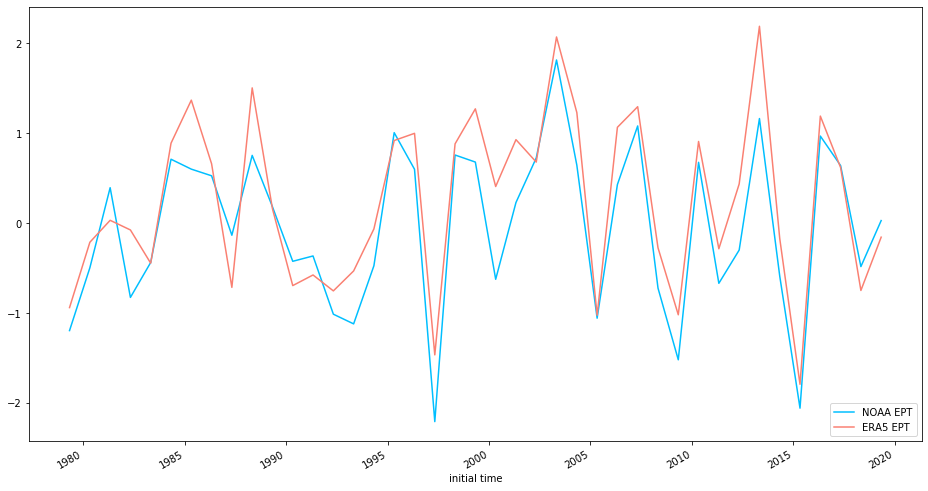

In [29]:
plt.figure(figsize=(16,8))
plt.title('Comparing EPT', fontsize = 'xx-large')
EPT.plot(label='NOAA EPT', color = 'deepskyblue')
ERA5EPT.plot(label='ERA5 EPT', color = 'salmon')
plt.legend(loc='lower right')

# CPT

In [30]:
#CP-ENSOpredictor
#NOAA

#DSST1
latrange1 = sst.sel(lat = slice(-10, -25)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = sst.sel(lat = slice(-10, -25), lon = slice(170, 200), time = (sst['time.month']==4))
aprilSST1 = aprildata1.sel(time = slice('1979-04-01', '2019-04-01'))
aprilmean1 = (aprilSST1*weights1).mean({'lon', 'lat'})/weights1.mean() 

maydata1 = sst.sel(lat = slice(-10, -25), lon = slice(170, 200), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2019-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() 

aprilmean1.time.data = maymean1.time.data
DSST1 = maymean1 - aprilmean1

#DSST2
latrange2 = sst.sel(lat = slice(20, 5)).lat
weights2 = np.cos(latrange2*np.pi/180)

aprildata2 = sst.sel(lat = slice(20, 5), lon = slice(180, 210), time = (sst['time.month']==4))
aprilSST2 = aprildata2.sel(time = slice('1979-04-01', '2019-04-01'))
aprilmean2 = (aprilSST2*weights2).mean({'lon', 'lat'})/weights2.mean() 
                          
maydata2 = sst.sel(lat = slice(20, 5), lon = slice(180, 210), time = (sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('1979-05-01', '2019-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean() 
                          
aprilmean2.time.data = maymean2.time.data
DSST2 = maymean2 - aprilmean2

CPT = DSST1 - DSST2
print("not normalized", CPT)
CPTstd = 0.243743
CPTmean = -1.087295
CPT = (CPT - CPTmean)/CPTstd
print("NOAA CPT", CPT)

not normalized <xarray.DataArray (time: 41)>
array([-0.877079, -1.555321, -1.133108, -1.112932, -1.007406, -1.351151,
       -1.230379, -1.243137, -1.480965, -1.106583, -0.945692, -0.58638 ,
       -1.271177, -1.207592, -1.113825, -1.194332, -0.976677, -1.409504,
       -1.250013, -0.615412, -1.438681, -1.347534, -1.209969, -1.230007,
       -0.844175, -0.977886, -1.073309, -0.789785, -0.992636, -1.090977,
       -1.246532, -0.948189, -0.808014, -0.980453, -1.071667, -1.003197,
       -1.024609, -0.905445, -1.119499, -0.715998, -1.286224], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2019-05-01
NOAA CPT <xarray.DataArray (time: 41)>
array([ 0.86245 , -1.920161, -0.187957, -0.105181,  0.327758, -1.082515,
       -0.587028, -0.639371, -1.615101, -0.079131,  0.580952,  2.055095,
       -0.75441 , -0.49354 , -0.108843, -0.439139,  0.453831, -1.321921,
       -0.667581,  1.935987, -1.441623, -1.067678, -0.50329 , -0.585502,
        0.997443,  0.44

In [31]:
#CP-ENSOpredictor
#NOAA

#DSST1
latrange1 = ERA5sst.sel(lat = slice(-10, -25)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = ERA5sst.sel(lat = slice(-10, -25), lon = slice(170, 200), time = (ERA5sst['time.month']==4))
aprilSST1 = aprildata1.sel(time = slice('1979-04-01', '2019-04-01'))
aprilmean1 = (aprilSST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

maydata1 = ERA5sst.sel(lat = slice(-10, -25), lon = slice(170, 200), time = (ERA5sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2019-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

aprilmean1.time.data = maymean1.time.data
DSST1 = maymean1 - aprilmean1

#DSST2
latrange2 = ERA5sst.sel(lat = slice(20, 5)).lat
weights2 = np.cos(latrange2*np.pi/180)

aprildata2 = ERA5sst.sel(lat = slice(20, 5), lon = slice(180, 210), time = (ERA5sst['time.month']==4))
aprilSST2 = aprildata2.sel(time = slice('1979-04-01', '2019-04-01'))
aprilmean2 = (aprilSST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15
                          
maydata2 = ERA5sst.sel(lat = slice(20, 5), lon = slice(180, 210), time = (ERA5sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('1979-05-01', '2019-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15
                          
aprilmean2.time.data = maymean2.time.data
DSST2 = maymean2 - aprilmean2

ERA5CPT = DSST1 - DSST2
print("not normalized", ERA5CPT)
CPTstd = 0.243743
CPTmean = -1.087295
ERA5CPT = (ERA5CPT - CPTmean)/CPTstd
print("ERA5 CPT", ERA5CPT)

not normalized <xarray.DataArray (time: 41)>
array([-0.916443, -1.100739, -1.311523, -0.788757, -1.440643, -1.19873 ,
       -1.072205, -1.372437, -1.631592, -0.955475, -0.610565, -0.657318,
       -1.001709, -1.363922, -1.317383, -1.387817, -1.118225, -1.319702,
       -0.99942 , -0.913147, -1.377899, -1.172913, -0.79895 , -1.393616,
       -0.951569, -1.123871, -1.313995, -0.899902, -0.77063 , -0.870056,
       -1.416046, -0.81604 , -0.733612, -1.088715, -1.23941 , -1.253357,
       -1.020752, -1.120209, -1.119019, -0.668304, -1.512268], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2019-05-01
ERA5 CPT <xarray.DataArray (time: 41)>
array([ 0.700952, -0.055154, -0.919938,  1.224805, -1.449675, -0.457184,
        0.061911, -1.169845, -2.233076,  0.540816,  1.955871,  1.764059,
        0.351132, -1.134913, -0.943977, -1.232947, -0.126896, -0.953492,
        0.360523,  0.714474, -1.192256, -0.351262,  1.182987, -1.256736,
        0.556842, -0.15

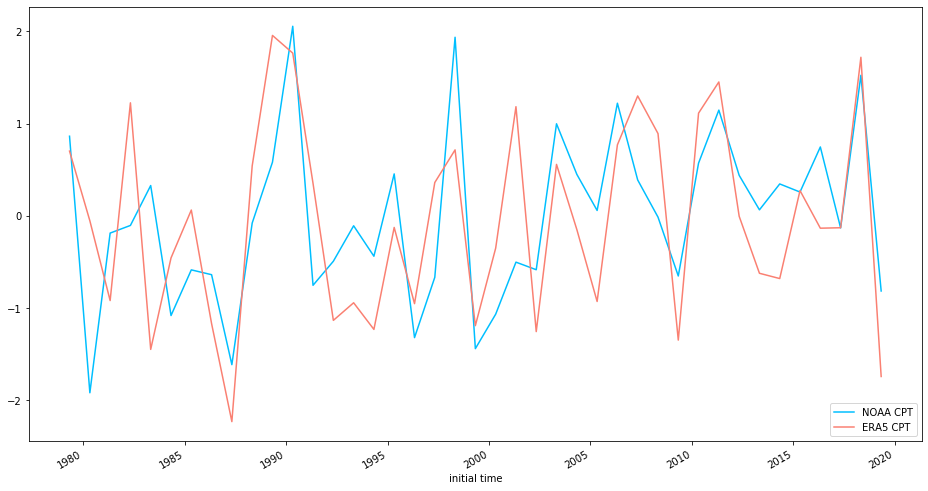

In [32]:
plt.figure(figsize=(16,8))
plt.title('Comparing CPT', fontsize = 'xx-large')
CPT.plot(label='NOAA CPT', color = 'deepskyblue')
ERA5CPT.plot(label='ERA5 CPT', color = 'salmon')
plt.legend(loc='lower right')

# PSH

In [33]:
#mega-ENSOpredictor

#NPcalculation
latrange1 = slp.sel(lat = slice(-10, -40)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = slp.sel(lat = slice(-10, -40), lon = slice(200, 270), time = (slp['time.month']==4))
aprilSLP1 = aprildata1.sel(time=slice('1979-04-01','2019-04-01'))
aprilmean1 = ((aprilSLP1*weights1).mean({'lon', 'lat'})/weights1.mean())

maydata1 = slp.sel(lat = slice(-10, -40), lon = slice(200, 270), time = (slp['time.month']==5))
maySLP1 = maydata1.sel(time = slice('1979-05-01', '2019-05-01'))
maymean1 = ((maySLP1*weights1).mean({'lon', 'lat'})/weights1.mean())

aprilmean1.time.data = maymean1.time.data
NP = ((aprilmean1 + maymean1)/2)

#SPcalculation
latrange2 = slp.sel(lat = slice(30, 10)).lat
weights2 = np.cos(latrange2*np.pi/180)

aprildata2 = slp.sel(lat = slice(30, 10), lon = slice(180, 230), time = (slp['time.month']==4))
aprilSLP2 = aprildata2.sel(time = slice('1979-04-01', '2019-04-01'))
aprilmean2 = ((aprilSLP2*weights2).mean({'lon', 'lat'})/weights2.mean())

maydata2 = slp.sel(lat = slice(30, 10), lon = slice(180, 230), time = (slp['time.month']==5))
maySLP2 = maydata2.sel(time = slice('1979-05-01', '2019-05-01'))
maymean2 = ((maySLP2*weights2).mean({'lon', 'lat'})/weights2.mean())

aprilmean2.time.data = maymean2.time.data
SP = ((aprilmean2 + maymean2)/2)

NParea = (30*weights1.mean() * 60)
SParea = (20*weights2.mean() * 50)
PSH = ((NP * NParea) + (SP * SParea))/(NParea + SParea)
print("not normalized", PSH)
PSHstd = 0.430541
PSHmean = 1015.898018
PSH = (PSH - PSHmean)/PSHstd
print("Hadley PSH", PSH)

not normalized <xarray.DataArray (time: 41)>
array([1015.369285, 1015.578792, 1015.4776  , 1015.444772, 1016.135217,
       1016.460457, 1016.036373, 1015.55654 , 1016.034757, 1016.45449 ,
       1016.299596, 1016.166051, 1015.505997, 1015.34733 , 1015.557042,
       1015.763202, 1015.679916, 1016.426659, 1014.740642, 1016.284865,
       1016.552542, 1016.419521, 1016.650116, 1015.597514, 1016.209822,
       1016.122535, 1016.222696, 1015.874155, 1017.637944, 1015.971944,
       1015.768805, 1017.879593, 1017.731951, 1016.752673, 1016.83261 ,
       1017.146023, 1015.775102, 1015.765541, 1016.97512 , 1016.77159 ,
       1016.879105])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2019-05-01
Hadley PSH <xarray.DataArray (time: 41)>
array([-1.228066, -0.741454, -0.976487, -1.052737,  0.550933,  1.306355,
        0.321351, -0.793137,  0.317597,  1.292494,  0.932728,  0.62255 ,
       -0.91053 , -1.279061, -0.79197 , -0.313133, -0.506576,  1.227854,
       -2.688

In [34]:
#mega-ENSOpredictor

#NPcalculation
latrange1 = ERA5slp.sel(lat = slice(-10, -40)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = ERA5slp.sel(lat = slice(-10, -40), lon = slice(200, 270), time = (ERA5slp['time.month']==4))
aprilSLP1 = aprildata1.sel(time=slice('1979-04-01','2019-04-01'))
aprilmean1 = ((aprilSLP1*weights1).mean({'lon', 'lat'})/weights1.mean())/100

maydata1 = ERA5slp.sel(lat = slice(-10, -40), lon = slice(200, 270), time = (ERA5slp['time.month']==5))
maySLP1 = maydata1.sel(time = slice('1979-05-01', '2019-05-01'))
maymean1 = ((maySLP1*weights1).mean({'lon', 'lat'})/weights1.mean())/100

aprilmean1.time.data = maymean1.time.data
NP = ((aprilmean1 + maymean1)/2)

#SPcalculation
latrange2 = ERA5slp.sel(lat = slice(30, 10)).lat
weights2 = np.cos(latrange2*np.pi/180)

aprildata2 = ERA5slp.sel(lat = slice(30, 10), lon = slice(180, 230), time = (ERA5slp['time.month']==4))
aprilSLP2 = aprildata2.sel(time = slice('1979-04-01', '2019-04-01'))
aprilmean2 = ((aprilSLP2*weights2).mean({'lon', 'lat'})/weights2.mean())/100

maydata2 = ERA5slp.sel(lat = slice(30, 10), lon = slice(180, 230), time = (ERA5slp['time.month']==5))
maySLP2 = maydata2.sel(time = slice('1979-05-01', '2019-05-01'))
maymean2 = ((maySLP2*weights2).mean({'lon', 'lat'})/weights2.mean())/100

aprilmean2.time.data = maymean2.time.data
SP = ((aprilmean2 + maymean2)/2)

NParea = (30*weights1.mean() * 60)
SParea = (20*weights2.mean() * 50)
ERA5PSH = ((NP * NParea) + (SP * SParea))/(NParea + SParea)
print("not normalized", ERA5PSH)
PSHstd = 0.430541
PSHmean = 1015.898018
ERA5PSH = (ERA5PSH - PSHmean)/PSHstd
print("ERA5 PSH", ERA5PSH)

not normalized <xarray.DataArray (time: 41)>
array([1014.711391, 1015.522859, 1015.567899, 1015.232909, 1016.53942 ,
       1016.761883, 1015.898192, 1015.182167, 1016.150934, 1016.69816 ,
       1016.157416, 1016.267135, 1015.213664, 1015.197739, 1015.71164 ,
       1015.774068, 1015.875184, 1016.973451, 1014.533236, 1017.10264 ,
       1016.954567, 1017.239374, 1016.910864, 1015.55472 , 1016.556657,
       1016.537996, 1016.12652 , 1015.760245, 1017.461745, 1015.677408,
       1015.442051, 1017.768824, 1017.504321, 1016.621829, 1016.672197,
       1016.961543, 1015.752919, 1015.735511, 1016.97483 , 1016.48547 ,
       1016.807179])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2019-05-01
ERA5 PSH <xarray.DataArray (time: 41)>
array([-2.756130e+00, -8.713655e-01, -7.667529e-01, -1.544822e+00,
        1.489758e+00,  2.006463e+00,  4.033741e-04, -1.662678e+00,
        5.874371e-01,  1.858456e+00,  6.024921e-01,  8.573327e-01,
       -1.589522e+00, -1.626510e+

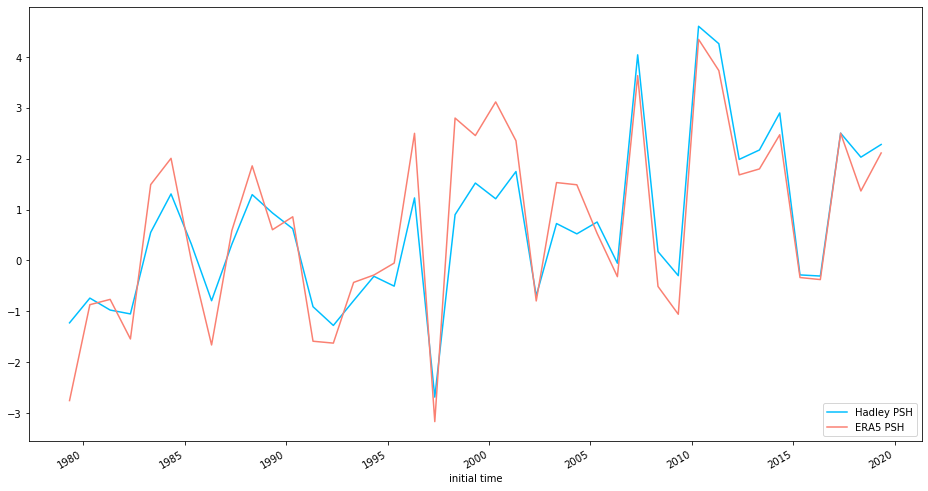

In [35]:
plt.figure(figsize=(16,8))
plt.title('Comparing PSH', fontsize = 'xx-large')
PSH.plot(label='Hadley PSH', color = 'deepskyblue')
ERA5PSH.plot(label='ERA5 PSH', color = 'salmon')
plt.legend(loc='lower right')

# NAT

In [36]:
#AnomalousAsianLowpredictor

latrange = slp.sel(lat = slice(60, 40)).lat
weights = np.cos(latrange*np.pi/180)

marchdata = slp.sel(lat = slice(60, 40), lon = slice(95, 125), time = (slp['time.month']==3))
marchSLP = marchdata.sel(time = slice('1979-03-01', '2019-03-01'))
marchmean = ((marchSLP*weights).mean({'lon', 'lat'})/weights.mean())

maydata = slp.sel(lat = slice(60, 40), lon = slice(95, 125), time = (slp['time.month']==5))
maySLP = maydata.sel(time = slice('1979-05-01', '2019-05-01'))
maymean = ((maySLP*weights).mean({'lon', 'lat'})/weights.mean())

marchmean.time.data = maymean.time.data
NAT = maymean - marchmean
print("not normalized", NAT)
NATstd = 1.648686
NATmean = -12.909709
NAT = (NAT - NATmean)/NATstd
print("Hadley NAT", NAT)

not normalized <xarray.DataArray (time: 41)>
array([-11.807617, -15.503784, -11.714355, -12.10437 , -14.550659, -13.497314,
       -15.191467, -12.831665, -11.989197, -14.522034, -11.29425 , -12.444458,
       -13.717285, -12.782898, -12.491272, -16.267395, -12.129761, -12.581299,
       -13.2099  , -12.784546, -11.362488, -12.99939 , -12.135864,  -8.766357,
       -11.892883, -12.373352, -14.332581,  -8.838928, -15.790039,  -9.223572,
       -13.383362, -14.19458 , -13.968994, -12.924805, -10.814575, -12.504822,
       -12.383484, -12.062744, -14.446899, -10.198425,  -9.85083 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2019-05-01
Hadley NAT <xarray.DataArray (time: 41)>
array([ 0.668467, -1.57342 ,  0.725034,  0.488473, -0.995308, -0.356408,
       -1.383986,  0.047337,  0.558331, -0.977945,  0.979846,  0.282195,
       -0.48983 ,  0.076916,  0.2538  , -2.036583,  0.473073,  0.199195,
       -0.182079,  0.075917,  0.938457, -0.0543

In [37]:
#AnomalousAsianLowpredictor

latrange = ERA5slp.sel(lat = slice(60, 40)).lat
weights = np.cos(latrange*np.pi/180)

marchdata = ERA5slp.sel(lat = slice(60, 40), lon = slice(95, 125), time = (ERA5slp['time.month']==3))
marchSLP = marchdata.sel(time = slice('1979-03-01', '2019-03-01'))
marchmean = ((marchSLP*weights).mean({'lon', 'lat'})/weights.mean())/100

maydata = ERA5slp.sel(lat = slice(60, 40), lon = slice(95, 125), time = (ERA5slp['time.month']==5))
maySLP = maydata.sel(time = slice('1979-05-01', '2019-05-01'))
maymean = ((maySLP*weights).mean({'lon', 'lat'})/weights.mean())/100

marchmean.time.data = maymean.time.data
ERA5NAT = maymean - marchmean
print("not normalized", ERA5NAT)
NATstd = 1.648686
NATmean = -12.909709
ERA5NAT = (ERA5NAT - NATmean)/NATstd
print("ERA5 NAT", ERA5NAT)

not normalized <xarray.DataArray (time: 41)>
array([-10.830505, -14.946899,  -9.006836, -10.416687, -14.303162, -13.421143,
       -14.165771, -10.346924, -10.951172, -13.737854,  -9.717773, -10.709351,
       -13.294678, -10.21167 , -11.4328  , -15.781677, -10.909424, -10.151611,
       -11.759155, -11.632874,  -8.541931, -10.836243, -10.118469,  -3.506104,
       -11.670166, -10.556091, -14.664246,  -8.211792, -15.066162,  -8.568054,
       -12.655579, -13.969299, -14.350403, -12.453735, -10.372192, -11.816345,
       -11.621948, -11.019714, -14.014404,  -9.502869,  -8.832336],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2019-05-01
ERA5 NAT <xarray.DataArray (time: 41)>
array([ 1.261128, -1.235645,  2.367263,  1.512127, -0.84519 , -0.310207,
       -0.761857,  1.554441,  1.187938, -0.502306,  1.936048,  1.334613,
       -0.2335  ,  1.636478,  0.89581 , -1.741974,  1.21326 ,  1.672907,
        0.697861,  0.774456,  2.649248,  1.257648

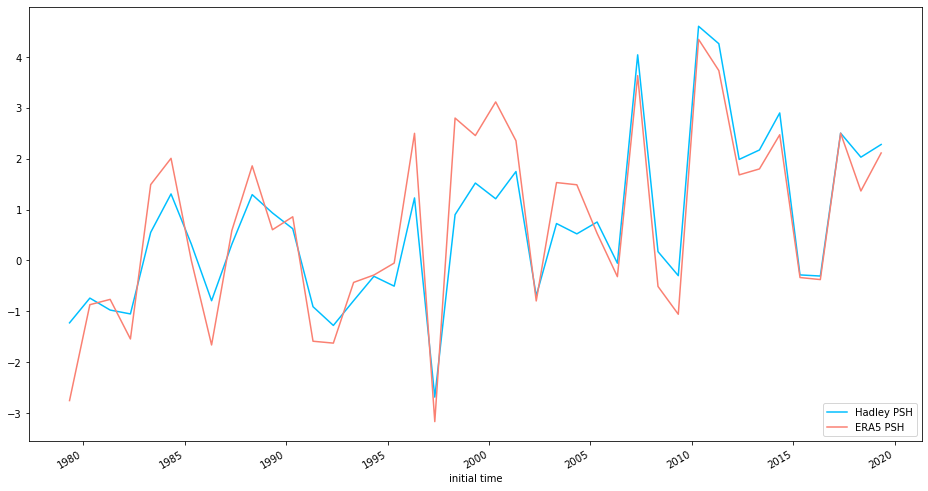

In [38]:
plt.figure(figsize=(16,8))
plt.title('Comparing PSH', fontsize = 'xx-large')
PSH.plot(label='Hadley PSH', color = 'deepskyblue')
ERA5PSH.plot(label='ERA5 PSH', color = 'salmon')
plt.legend(loc='lower right')

# Precipitation

In [43]:
#precipitation

junenumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 6):
        junenumber.append(x)
junedata = precipALLIN.sel(time = precipALLIN['time.month']==6, int = junenumber)
juneprecipALLIN = junedata.data[junenumber]

julynumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 7):
        julynumber.append(x)
julydata = precipALLIN.sel(time = precipALLIN['time.month']==7, int = julynumber)
julyprecipALLIN = julydata.data[julynumber]

augustnumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 8):
        augustnumber.append(x)
augustdata = precipALLIN.sel(time = precipALLIN['time.month']==8, int = augustnumber)
augustprecipALLIN = augustdata.data[augustnumber]

septembernumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 9):
        septembernumber.append(x)
septemberdata = precipALLIN.sel(time = precipALLIN['time.month']==9, int = septembernumber)
septemberprecipALLIN = septemberdata.data[septembernumber]

rainfallforAIRIfull = juneprecipALLIN.data + julyprecipALLIN.data + augustprecipALLIN.data + septemberprecipALLIN.data

rainfall = []
for y in range(89):
    rainfall.append(rainfallforAIRIfull[y+29])
print(rainfall)

rainfallstd = np.std(rainfall)
rainfallmean = np.mean(rainfall)

print()
print("rainfallstd", rainfallstd)
print("rainfallmean", rainfallmean)

[889.3, 722.0, 791.80005, 860.8, 750.3, 716.4, 884.89996, 777.49994, 897.0, 889.3, 934.89996, 736.30005, 805.80005, 784.4, 898.0, 780.6, 950.6, 1004.2, 650.8, 884.5, 719.0, 865.8, 869.0, 823.0, 862.6, 803.60004, 902.6, 853.0, 767.7, 821.1, 804.4, 877.0, 803.4, 975.8, 913.39996, 843.5, 908.19995, 841.89996, 908.19995, 789.4, 853.1, 728.30005, 957.69995, 868.2001, 920.3, 910.80005, 903.60004, 945.3, 873.89996, 903.69995, 876.9, 738.8, 792.9, 922.89996, 885.30005, 930.0, 983.2, 788.5, 889.3, 944.1, 839.7, 1020.2, 809.8, 857.9, 922.5, 709.39996, 739.9, 860.1, 754.6, 831.0, 939.8, 886.8, 652.8, 913.4, 748.0, 962.7, 856.80005, 883.2, 909.30005, 707.7, 882.8, 852.19995, 735.4, 955.60004, 836.7, 759.8, 743.0, 697.1, 961.5]

rainfallstd 82.409775
rainfallmean 847.2865


# Model

original datasets <xarray.DataArray (time: 41)>
array([-0.841861, -0.391936, -0.249375, -0.768641,  0.221423,  0.514178,
        0.576565, -0.068022, -0.431741,  0.870944,  0.174719,  0.265613,
       -0.407606, -0.883487, -0.791572,  0.10981 ,  0.329057,  0.264809,
       -1.74074 ,  0.912205,  0.169551, -0.205628,  0.300713, -0.534271,
        1.061409,  0.429389, -0.106603, -0.172185,  1.930682, -0.840727,
       -0.839926,  1.67173 ,  1.036083,  0.400529,  0.753234,  0.396013,
       -1.062325,  0.402801,  1.074661,  0.133428, -0.063379])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2019-05-01
ERA5 <xarray.DataArray (time: 41)>
array([-1.245925, -0.014958, -0.905052, -0.521823,  0.059829,  0.866809,
        0.837761, -0.667517, -0.911034,  1.357932,  0.119899, -0.115361,
       -0.514683, -1.337639, -0.744714,  0.086845,  0.104315,  0.461212,
       -1.518069,  1.00773 ,  0.299648,  0.539045,  0.795893, -1.47206 ,
        1.250918,  0.548594, -0.282078,

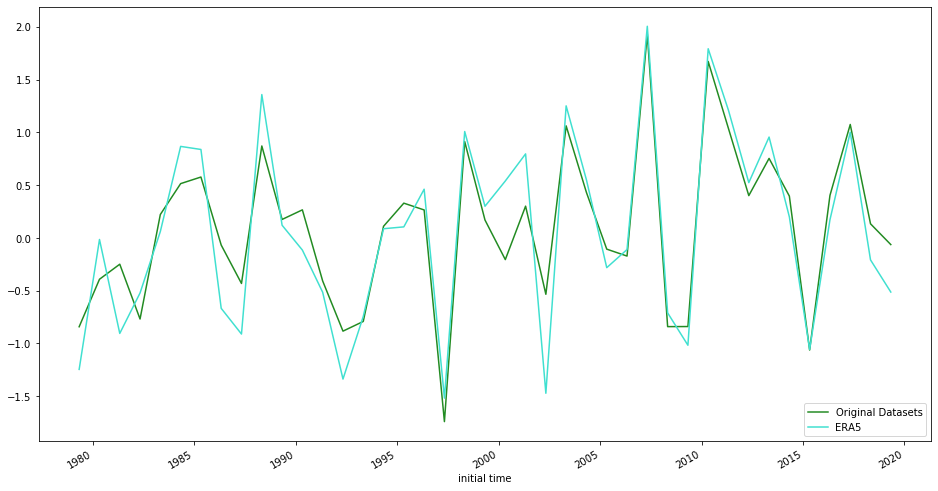

In [41]:
#Dr. Wang's coefficients
AIRI = 0.47*EPT + 0.19*CPT + 0.23*PSH - 0.24*NAT
print("original datasets", AIRI)

ERA5AIRI = 0.47*ERA5EPT + 0.19*ERA5CPT + 0.23*ERA5PSH - 0.24*ERA5NAT
print("ERA5", ERA5AIRI)

plt.figure(figsize=(16,8))
plt.title('Comparing AIRI', fontsize = 'xx-large')
AIRI.plot(label='Original Datasets', color = 'forestgreen')
ERA5AIRI.plot(label='ERA5', color = 'turquoise')
plt.legend(loc='lower right')

original datasets final <xarray.DataArray (time: 41)>
array([ 777.908954,  814.987136,  826.735522,  783.942937,  865.533886,
        889.659783,  894.801123,  841.680839,  811.706842,  919.060779,
        861.685061,  869.1756  ,  813.695754,  774.478534,  782.053212,
        856.335911,  874.404033,  869.109317,  703.832519,  922.461067,
        861.259187,  830.340754,  872.068179,  803.257362,  934.756994,
        882.672309,  838.501342,  833.096801, 1006.393588,  778.002344,
        778.068383,  985.053365,  932.669866,  880.294028,  909.36038 ,
        879.921882,  759.740567,  880.481239,  935.84906 ,  858.282269,
        842.063482])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2019-05-01
ERA5 final <xarray.DataArray (time: 41)>
array([ 744.610072,  846.053793,  772.701395,  804.283155,  852.216974,
        918.720068,  916.32622 ,  792.276532,  772.208421,  959.193388,
        857.167377,  837.779665,  804.871582,  737.052005,  785.91476 ,
       

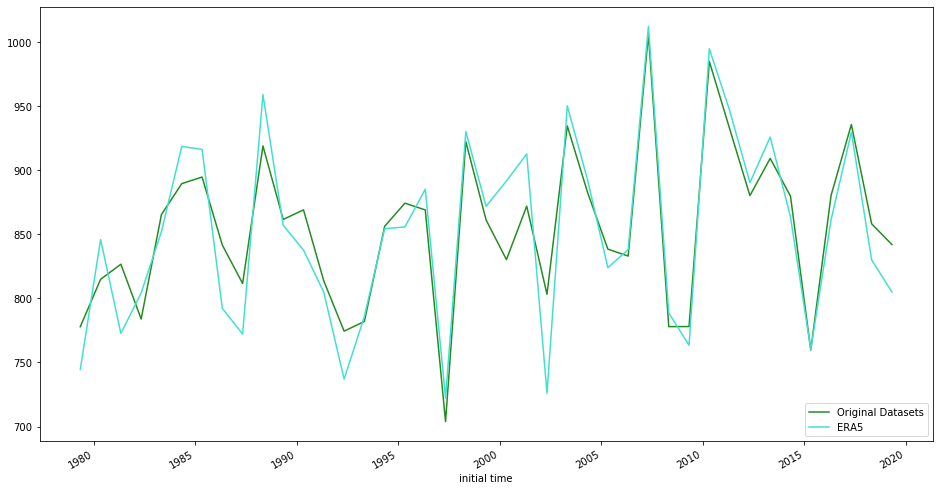

In [44]:
final = (AIRI * rainfallstd) + rainfallmean
print("original datasets final", final)

ERA5final = (ERA5AIRI * rainfallstd) + rainfallmean
print("ERA5 final", ERA5final)

plt.figure(figsize=(16,8))
plt.title('Comparing final', fontsize = 'xx-large')
final.plot(label='Original Datasets', color = 'forestgreen')
ERA5final.plot(label='ERA5', color = 'turquoise')
plt.legend(loc='lower right')

In [ ]:
# Copyright (c) 2020 Medha Palavalli.